рекуррентная нейронная сеть Элмана

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
ex_count = 30 #  количество примеров
seq_len = 8  #  длинна последовательности
input_size = 11 # размер одного элемента последовательности
class_count = 3 #  количество классов
hl_size = 7 # размер скрытого слоя

In [3]:
X = np.random.rand(ex_count,input_size,seq_len) # последовательности
y = np.random.randint(0,class_count,ex_count) # номера классов
y = OneHotEncoder(sparse=False,categories='auto').fit_transform(y.reshape(-1, 1))

In [4]:
X.shape, y.shape

((30, 11, 8), (30, 3))

In [5]:
net_size = [ input_size, hl_size, class_count ] # размеры слоёв сети
net_size

[11, 7, 3]

In [6]:
# инициализация весов

# матрица весов первого (скрытого) слоя 
W1  = np.random.normal(loc=0.0, scale=.1, size=(input_size,hl_size))
# матрица весов обратных связей скрытого слоя
W1r = np.random.normal(loc=0.0, scale=.1, size=(hl_size,hl_size))
# вектор сдвигов скрытого слоя
S1  = np.zeros(hl_size)

# матрица весов выходного слоя 
W2  = np.random.normal(loc=0.0, scale=.1, size=(hl_size,class_count))
# вектор сдвигов выходного слоя
S2  = np.zeros(class_count)

( 
W1.shape, 
W1r.shape, 
S1.shape,
W2.shape, 
S2.shape 
)


((11, 7), (7, 7), (7,), (7, 3), (3,))

---

In [7]:
# активация скрытого слоя
def act1(x): return np.tanh(x)
def act1_drv(x):return 1.0/(np.cosh(x)**2)

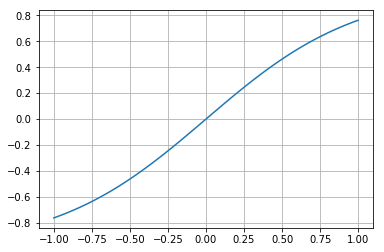

In [8]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act1(jj) )
plt.grid()
plt.show()

---

In [9]:
# активация выходного слоя
def act2(x): 
    xe = np.exp(x)
    return xe/xe.sum(axis=1).reshape(-1,1)

def act2_drv(x): return 1.0 

---

In [10]:
# функция потери - средняя кросс-энтропия
def loss(o,y):
    o_restr = np.minimum(0.99999,np.maximum(1e-9,o))
    return -( y*np.log(o_restr) + (1-y)*np.log(1.0-o_restr) ).sum() / y.shape[0]    

In [11]:
def run(x,w1,w1r,s1,w2,s2):
    # начальное состояние скрытого слоя
    o = np.zeros( [ex_count, hl_size] )
    seq_len = x.shape[2] # длинна последовательностей
    for i in range(seq_len): o = act1( x[:,:,i].dot(w1) + o.dot(w1r) + s1 )
    return act2( o.dot(w2) + s2 )

In [15]:
# o = run(X,W1,W1r,S1,W2,S2)
# loss(o,y)

1.9064246460517407

In [16]:
def rnn_bptt_forward(x,w1,w1r,s1,w2,s2):
    seq_len = x.shape[2] # длинна последовательностей
    
    hs = [] # история состояний скрытого слоя
    ho = [] # история выходов скрытого слоя
    h = np.zeros( [ex_count, hl_size] ) # начальное состояние выхода скрытого слоя
    
    for i in range(seq_len): 
        h = x[:,:,i].dot(w1) + h.dot(w1r) + s1 
        hs.append(h)
        h = act1(h)
        ho.append(h)

    o = act2( h.dot(w2) + s2 )
    
    return hs,ho,o

In [80]:
def rnn_bptt_backward(w1r,w2,y,o,hs):
    seq_len = len(hs) # длинна последовательностей
    e2 = o - y # ошибка выходного слоя
    # ошибка скрытого слоя на последнем элементе входной последовательности
    e1 = [ e2.dot(w2.T) * act1_drv( hs[-1] ) ]
    # ошибка скрытого слоя на элементе входной последовательности номер t
    for t in range(seq_len-2,-1,-1): 
        e1.append( e1[-1].dot(w1r.T) * act1_drv( hs[t] ) )
     
    e1 = list(reversed( e1)) 
    
    return e2,e1

In [93]:
def rnn_bptt_gradient(x,w1,w1r,s1,w2,s2,e1,e2,ho):
    seq_len = len(hs) # длинна последовательностей

    dw2 = hs[-1].T.dot(e2)
    ds2 = e2.sum(axis=0)

    t=0
    xt = x[:,:,t]
    dw1 = xt.T.dot( e1[t] )
    dw1r = 0.0
    ds1 = e1[t].sum(axis=0)

    for t in range(1,seq_len):
        xt = X[:,:,t]
        dw1 += xt.T.dot( e1[t] )
        ds1 += e1[t].sum(axis=0)
        dw1r += ho[t].T.dot( e1[t] )

    return dw1,dw1r,ds1,dw2,ds2    


In [94]:
hs,ho,o = rnn_bptt_forward(X,W1,W1r,S1,W2,S2)
e2,e1 = rnn_bptt_backward(W1r,W2,y,o,hs)
dW1,dW1r,dS1,dW2,dS2  = rnn_bptt_gradient(X,W1,W1r,S1,W2,S2,e1,e2,ho)

In [87]:
# seq_len = len(hs) # длинна последовательностей

# dW2 = hs[-1].T.dot(e2)
# dS2 = e2.sum(axis=0)

# t=0
# Xt = X[:,:,t]
# dW1 = Xt.T.dot( e1[t] )
# dS1 = e1[t].sum(axis=0)
# dW1r = 0.0

# for t in range(1,seq_len):
#     Xt = X[:,:,t]
#     dW1 += Xt.T.dot( e1[t] )
#     dS1 += e1[t].sum(axis=0)
#     dW1r += hs[t].T.dot( e1[t] )

    
    
#    for t = 2:m,
#       Xt = reshape( X(:,t,:) , [n,k] ) ; % элементы последовательностей номер t для всех примеров 
#       dW{1}{1} += er{1}{t} * transpose( Xt ) ;
#       dW{1}{2} += er{1}{t} * transpose( h{t-1} ) ;
#       dW{1}{3} += sum(er{1}{t},2) ;
#    endfor


# W1.shape, dW1.shape, dS1.shape

#    dW{1}{1} = er{1}{t} * transpose( Xt ) ;
#    dW{1}{2} = 0.0 ;
#    dW{1}{3} = sum(er{1}{t},2) ; 

# W2.shape, dW2.shape,dS2.shape

In [ ]:
# % - - - - - - - - - - - - - - - - 
# function retval = rnn_bptt_gradient(X,W,s,er,h),
#    % вычисляем значения градиента для всех весов

#    dW ={} ;

#    dW{2}{1} = er{2} * transpose( h{end} )  ; % 3x7 =  3x100 * 100x7
#    dW{2}{2} = sum(er{2},2) ;

#    % размеры матриц: 7x11 , 7x7 , 3x7 

#    n = size(X,1) ; % размер одного элемента последовательности
#    m = size(X,2) ; % длинна последовательности
#    k = size(X,3) ; % количество примеров

#    t = 1 ; % выбираем первый элемент последовательности
#    Xt = reshape( X(:,t,:) , [n,k] ) ; % элементы последовательностей номер t для всех примеров 


#    dW{1}{1} = er{1}{t} * transpose( Xt ) ;
#    dW{1}{2} = 0.0 ;
#    dW{1}{3} = sum(er{1}{t},2) ; 

#    for t = 2:m,
#       Xt = reshape( X(:,t,:) , [n,k] ) ; % элементы последовательностей номер t для всех примеров 
#       dW{1}{1} += er{1}{t} * transpose( Xt ) ;
#       dW{1}{2} += er{1}{t} * transpose( h{t-1} ) ;
#       dW{1}{3} += sum(er{1}{t},2) ;
#    endfor

#    retval = dW ;

# endfunction

In [ ]:
# % - - - - - - - - - - - - - - - - 
# function retval = rnn_bptt_backward(W,y,o,s) ,
#    % обратный проход
#    % для каждого примера:
#    % вычисляем ошибку выходного слоя
#    % вычисляем ошибку скрытого слоя для последнего элемента входной последовательности
#    % последовательно, в обратном порядке, вычисляем ошибки скрытого слоя для всех элементов входной последовательности


#    % формируем "правильный" выход сети из номера класса
#    d = zeros( size(o) ) ; 
#    for i = 1:length(y),
#       d(y(i),i) = 1 ; 
#    endfor

   
#    m = length(s) ; % длинна последовательности

#    er{2} = o - d ; % ошибка выходного слоя

#    % вычисляем ошибку скрытого слоя для всех элементов входной последовательности 
#    % начиная с последнего (в обратном порядке)

#    % ошибка скрытого слоя на последнем элементе входной последовательности
#    er{1}{m} = transpose( W{2}{1} ) * er{2} .* rnn_activate_drv( s{end} ) ; 

#    for t = m-1:-1:1, 
#       % ошибка скрытого слоя на элементе входной последовательности номер t
#       er{1}{t} = transpose( W{1}{2} ) * er{1}{t+1} .* rnn_activate_drv( s{t} ) ; 
#    endfor

#    retval = er ;

# endfunction


In [ ]:
# function [o,s,h] = rnn_bptt_forward(X,W),
#    % прямой проход
#    % для каждого примера:
#    % последовательно вычисляем состояния скрытого слоя s для всех элементов входной последовательности
#    % вычисляем выход сети о

#    n = size(X,1) ; % размер одного элемента последовательности
#    m = size(X,2) ; % длинна последовательности
#    k = size(X,3) ; % количество примеров


#    hs = [ size(W{1}{2},1), 1 ] ; % размер скрытого слоя
#    ht = zeros(hs) ; % начальное значение выходов скрытого слоя 
   
#    s = {} ; % история состояний скрытого слоя
#    h = {} ; % история выходов скрытого слоя
#    for t = 1:m,
#       Xt = reshape( X(:,t,:) , [n,k] ) ; % элементы последовательностей номер t для всех примеров 
#       st = W{1}{1}*Xt + W{1}{2}*ht + W{1}{3} ; % состояния скрытого слоя 
#       ht = rnn_activate( st ) ; % выходы скрытого слоя
#       s{t} = st ; % сохраняем историю состояний скрытого слоя
#       h{t} = ht ; % сохраняем историю выходов скрытого слоя
#    endfor

#    o = softmax( W{2}{1} * ht + W{2}{2} ) ;

# endfunction



In [ ]:
# % метод простого градиентного спуска
# function [W,er_hist] = rnn_fit_gradient_descent(W,X,y,Xc,yc),
#    a = 0.05 ; % скорость обучения
#    er_max = 0.07 ; % порог допустимой ошибки
#    n = 4e3 ; % максимальное количество эпох обучения
  
#    er_hist = [] ; % история изменения ошибки	 
#    for j = 1:n,
#       l = rnn_loss(Xc,W,yc) ;
#       er_hist = [ er_hist , l ] ;
#       printf("[i] эпоха %i/%i, ошибка обучения: %f/%f     \r",j,n, l,er_max) ;
#       if l < er_max, break; endif
#       dW = rnn_gradient(X,W,y) ; % вычисляем значения градиента 
#       dW = rnn_weight_norm(dW) ; % нормируем градиент
#       W = rnn_weight_correct(W,dW,a) ; % изменяем веса
#    endfor 
#    printf("\n");

# endfunction

# % - - - - - - - - - - - - - - - - 
# function retval = rnn_weight_correct(W,dW,a),
   
#    W{1}{1} -= a * dW{1}{1} ;
#    W{1}{2} -= a * dW{1}{2} ;
#    W{1}{3} -= a * dW{1}{3} ;
#    W{2}{1} -= a * dW{2}{1} ;
#    W{2}{2} -= a * dW{2}{2} ;

#    retval = W ;
# endfunction